In [ ]:
from pandas_datareader import data 
import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np
from scipy.stats import norm 
import pyfolio as pf 

from matplotlib.ticker import FuncFormatter
%matplotlib inline

C:\Users\huajuan.tan.2019\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\huajuan.tan.2019\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\huajuan.tan.2019\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\huajuan.tan.2019\AppData\Local\Continuum\anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [ ]:
## declare tickers& weights (3m)
portfolio_tickers = ['SPY','AMZN','AAPL'] 
weights = [0.5, 0.5, 0.0]

start_date = '2021-07-01'
end_date = '2021-09-30'
panel_data = data.DataReader(portfolio_tickers,'yahoo', start_date, end_date) 

closes_3m = panel_data[['Close', 'Adj Close']]
closes_3m = closes_3m.loc[start_date: end_date]

#portfolio returns
return_series_adj = (closes_3m['Adj Close'].pct_change()+ 1).cumprod() - 1 
weighted_return_series_adj = weights* (return_series_adj) 
return_series_adj = weighted_return_series_adj.sum(axis=1)


In [ ]:
# // Close & Adj Close for SPY, AMZN, and AAPL for the year 2020. Do a quick check to ensure there are no missing values.

tickers = ['XLE', 'XLF', 'XLK', 'XLRE', 'XLY', 'XLI', 'XLB', 'XLC', 'XLV', 'XLP', 'XLU'] 
# extract- 3m (for corr; rt- use 2y;)
start_date = '2021-07-01'
end_date = '2021-09-30'

# start_date = '2019-01-01'
# end_date = '2020-12-31'
panel_data = data.DataReader(tickers,'yahoo', start_date, end_date) 
#Use loc method to ensure we do not consider extra days of data panel_data = panel_data.loc['2020-01-01':'2020-12-31']
sector_closes_3m = panel_data[['Close', 'Adj Close']]
sector_closes_3m = sector_closes_3m.loc[start_date: end_date]

# sector_closes_3m.head()
# closes_3m.isnull().sum()

In [ ]:
weighted_closes= pd.DataFrame((weights* closes_3m["Close"]).sum(axis=1))
weighted_closes = weighted_closes.rename(columns={0: 'portfolio'})
all_closes_3m = sector_closes_3m["Close"].join(weighted_closes)

In [ ]:
return_series_close = (all_closes_3m.pct_change()+ 1).cumprod() - 1 
correlation = pd.DataFrame(return_series_close.corr().tail(1).round(3))
# correlation

In [ ]:
correlation = correlation.sort_values(by = "portfolio", axis=1)
top3_inverse_sectors= correlation.columns.tolist()[0:3]
# top3_inverse_sectors

In [ ]:
# select 3 representative tickers by sectors;
sector_dict= {
  'XLB': ['LIN', 'ECL', 'GOLD'],'XLC': ['GOOGL', 'FB', 'NFLX'],'XLY': ['AMZN', 'TSLA', 'NKE'],'XLP': ['KO', 'WMT', 'PEP'],'XLE': ['XOM', 'CVX', 'PSX'],'XLF': ['V', 'MA', 'JPM'],'XLV': ['JNJ', 'PFE', 'UNH'],'XLI': ['HON', 'GE', 'FDX'],'XLR': ['AMT', 'CCI', 'PSA'],'XLK': ['MSFT', 'AAPL', 'CRM'],'XLU': ['NEE', 'DUK', 'XEL']
}

In [ ]:
inverse_sector_tickers= []
for t in top3_inverse_sectors:
    for x in sector_dict[t]:
        inverse_sector_tickers.append(x)


In [ ]:
# use 2y for rs
start_date = '2019-01-01'
end_date = '2020-12-31'
panel_data = data.DataReader(inverse_sector_tickers,'yahoo', start_date, end_date) 

sector_closes_2y = panel_data[['Adj Close']]
sector_closes_2y = sector_closes_2y.loc[start_date: end_date]
# closes_2y.isnull().sum()

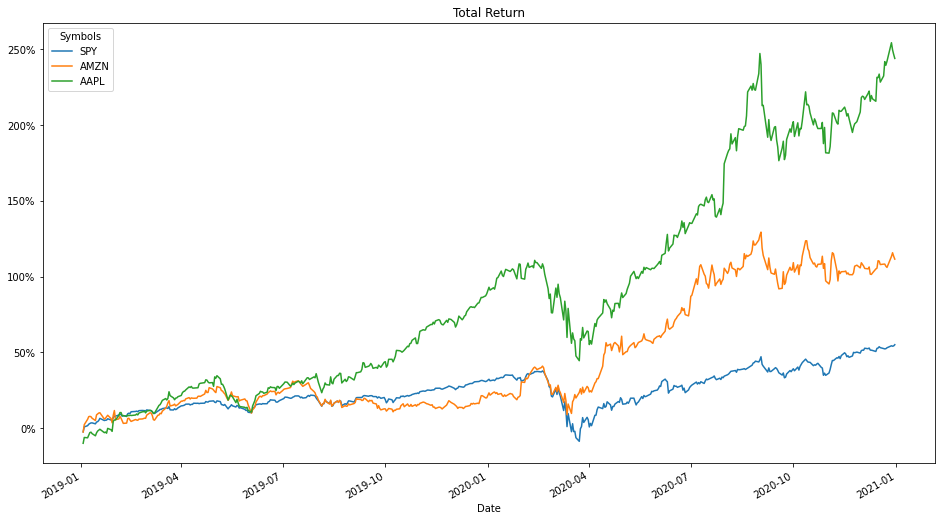

In [ ]:
###########################################################
## portfolio_2y_return_series_adj
###########################################################
# portfolio_tickers = ['SPY','AMZN','AAPL'] 
# weights = [0.5, 0.5, 0.0]
# start_date = '2019-01-01'
# end_date = '2020-12-31'

panel_data = data.DataReader(portfolio_tickers,'yahoo', start_date, end_date) 

closes_2y = panel_data[['Adj Close']]
closes_2y = closes_2y.loc[start_date: end_date]

# // return series for the period and plot the returns on a single chart.
return_series_adj = (closes_2y['Adj Close'].pct_change()+ 1).cumprod() - 1 
ret_ax = return_series_adj.plot(figsize=(16,9), title= "Total Return")
ret_ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#portfolio returns
weighted_return_series_adj_2y = weights* (return_series_adj) 
return_series_adj_2y = weighted_return_series_adj_2y.sum(axis=1)


In [ ]:
###########################################################
##Efficient Frontiner from Modern Portfolio Theory
###########################################################
import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
###########################################################
##Random Portfolios Generation
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

###########################################################
##Efficient Frontier
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns)* np.sqrt(252)
    an_rt = mean_returns* 252

    ret_list= [round(rp,2), round(sdp,2), max_sharpe_allocation.iloc[0, 0], max_sharpe_allocation.iloc[0, 1], round(rp_min,2), round(sdp_min,2), min_vol_allocation.iloc[0, 0], min_vol_allocation.iloc[0, 1]]

    for i, txt in enumerate(table.columns):
        ret_list.append(round(an_rt[i],2))
        ret_list.append(round(an_vol[i],2))
    ret_list.append(pd.DataFrame(mean_returns).index.tolist()[0])
    return ret_list

#####################################################################  
## content for each sector in ret_list
#####################################################################
# Maximum Sharpe Ratio Portfolio Allocation

# 1) Annualised Return: 0.39
# 2) Annualised Volatility: 0.29
#              JPM  portfolio
# 3) allocation- sector ticker  6.81      
# 4) allocation- portfolio 93.19

#####################################################################
# Minimum Volatility Portfolio Allocation

# 5) Annualised Return: 0.36
# 6) Annualised Volatility: 0.28
#              JPM  portfolio
# 7) allocation- sector ticker  28.11    
# 8) allocation- portfolio 71.89
#####################################################################
# Individual Stock Returns and Volatility

# 9) annuaised return- sector ticker;
# 10) annualised volatility- sector ticker;
# 11) annuaised return- portfolio;
# 12) annualised volatility- portfolio;

# 13) ticker_symbol
#####################################################################

In [ ]:
#2y
# portfolio_tickers = ['SPY','AMZN','AAPL'] 
start_date = '2019-01-01'
end_date = '2020-12-31'
panel_data = data.DataReader(portfolio_tickers,'yahoo', start_date, end_date) 
closes_2y = panel_data['Adj Close']
closes_2y = closes_2y.loc[start_date: end_date]


weighted_closes_2y= pd.DataFrame((weights* closes_2y).sum(axis=1))
weighted_closes_2y= weighted_closes_2y.reset_index()
weighted_closes_2y= weighted_closes_2y.rename(columns={"Date": "date", 0: "adj_close"})
weighted_closes_2y["ticker"]= "portfolio"


In [ ]:
sector_res= []
for t in inverse_sector_tickers:

    panel_data= pd.DataFrame()
    t_data = data.DataReader(t,'yahoo', start_date, end_date) 
    
    t_data = t_data.loc[start_date: end_date]
    t_data = t_data[['Adj Close']]
    
    t_data= t_data.reset_index()
    t_data["ticker"]= t
    t_data= t_data.rename(columns={"Date": "date", t_data.columns[1]: "adj_close"})
    panel_data= panel_data.append(t_data)

    
    panel_data= panel_data.append(weighted_closes_2y)
    
    df = panel_data.set_index('date')
    df.head()
    
    table = df.pivot(columns='ticker')
    table.columns = [col[1] for col in table.columns]
    table.head()
    
    returns = table.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    risk_free_rate = 0.0178
    sector_res.append(display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate))

# print(sector_res)

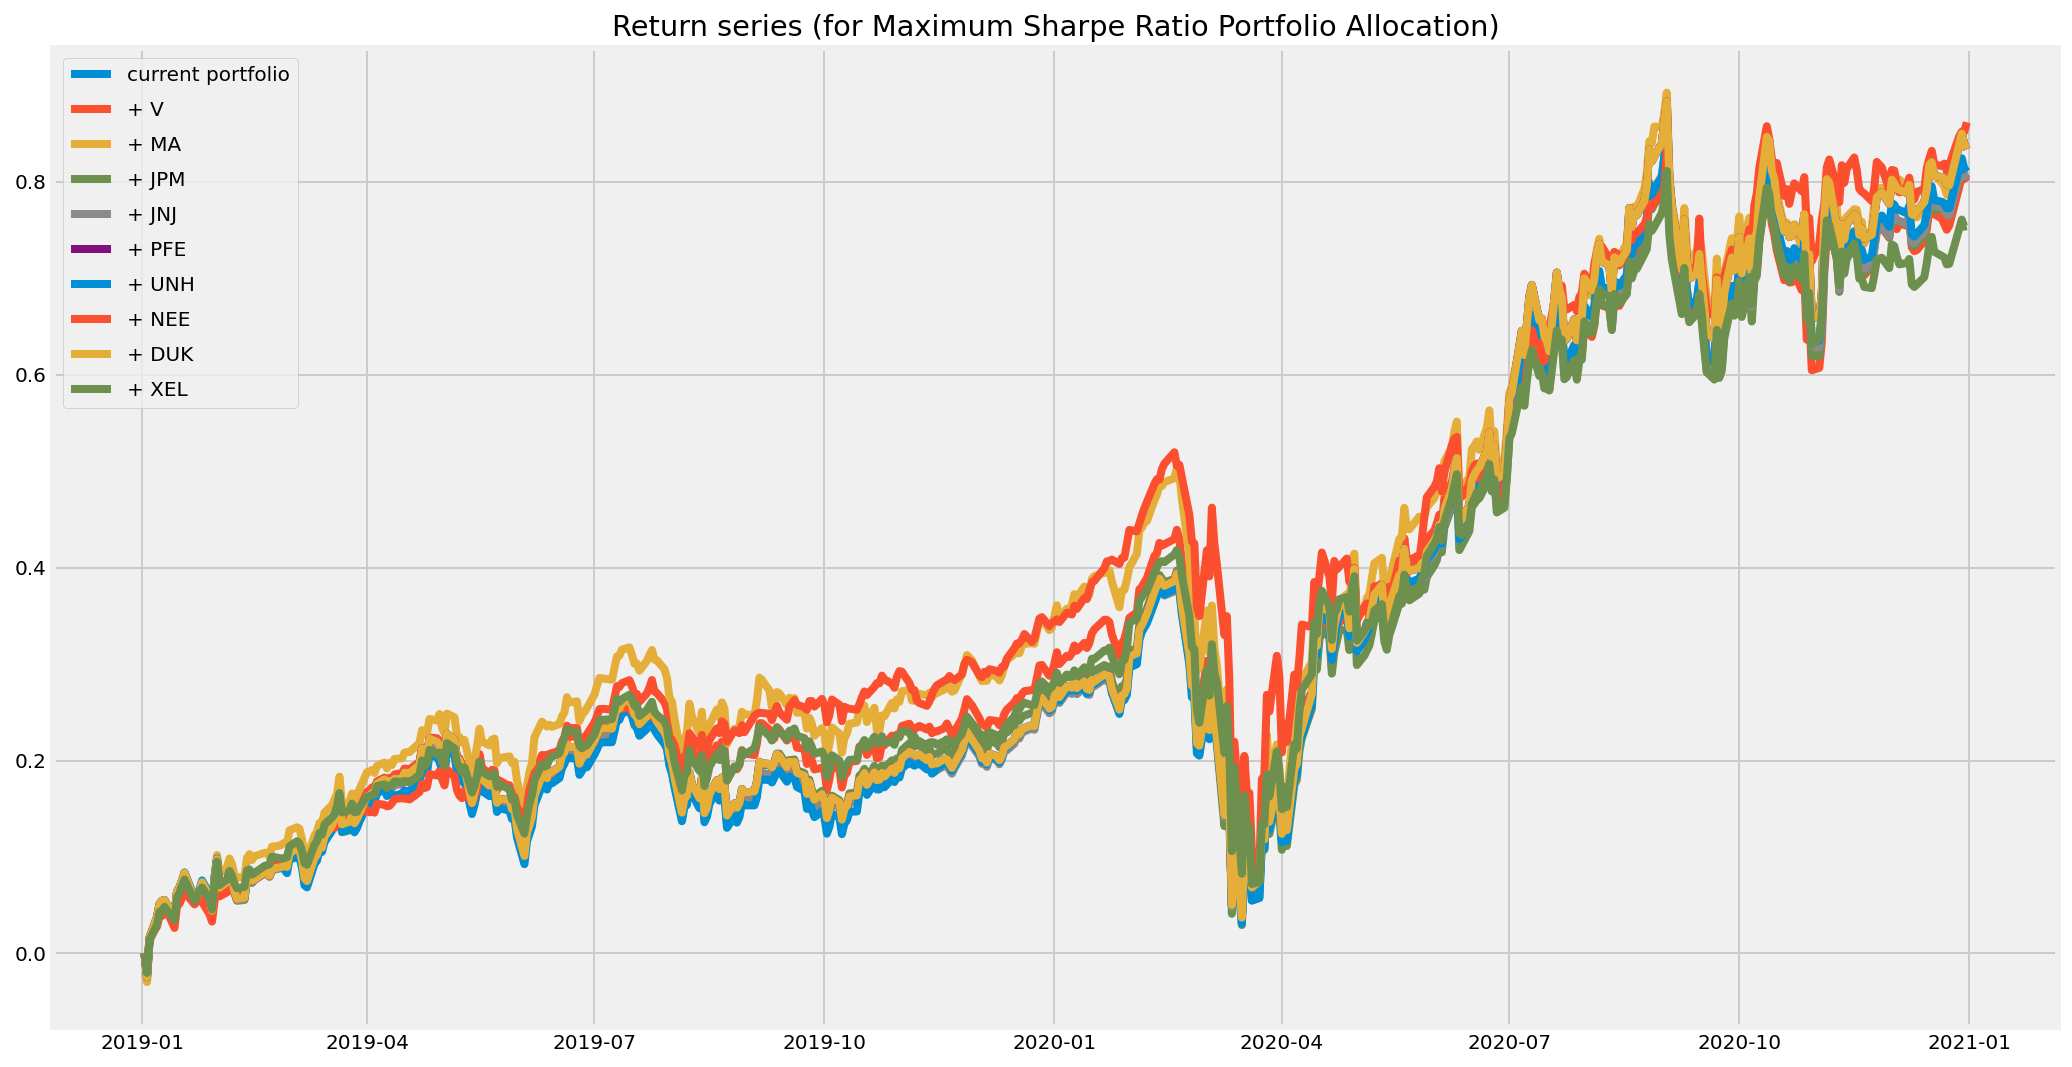

In [ ]:
###########################################################
## Maximum Sharpe Ratio Portfolio Allocation
###########################################################

##Plot the weighted returns and individual returns on the same plot for comparison
fig, ax = plt.subplots(figsize=(16,9)) 

ax.plot(return_series_adj_2y, label = 'current portfolio') 

for sector in sector_res:
    #portfolio returns
    weights = [sector[2], sector[3]]
    sector_closes_2y_return_series_adj = (sector_closes_2y['Adj Close'].pct_change()+ 1).cumprod() - 1 
    return_series_adj_2y_new_sector= pd.DataFrame(sector_closes_2y_return_series_adj[sector[12]]).join(pd.DataFrame(return_series_adj_2y)).rename(columns={0: 'portfolio'})
    weighted_return_series_adj = weights* (return_series_adj_2y_new_sector) 

    #Sum the weighted returns for portfolio
    df = weighted_return_series_adj.sum(axis=1)/100
    ax.plot(df, label= "+ "+ sector[12]) 
ax.set_title("Return series (for Maximum Sharpe Ratio Portfolio Allocation)")
ax.legend()
ax.legend(labelspacing=0.8)

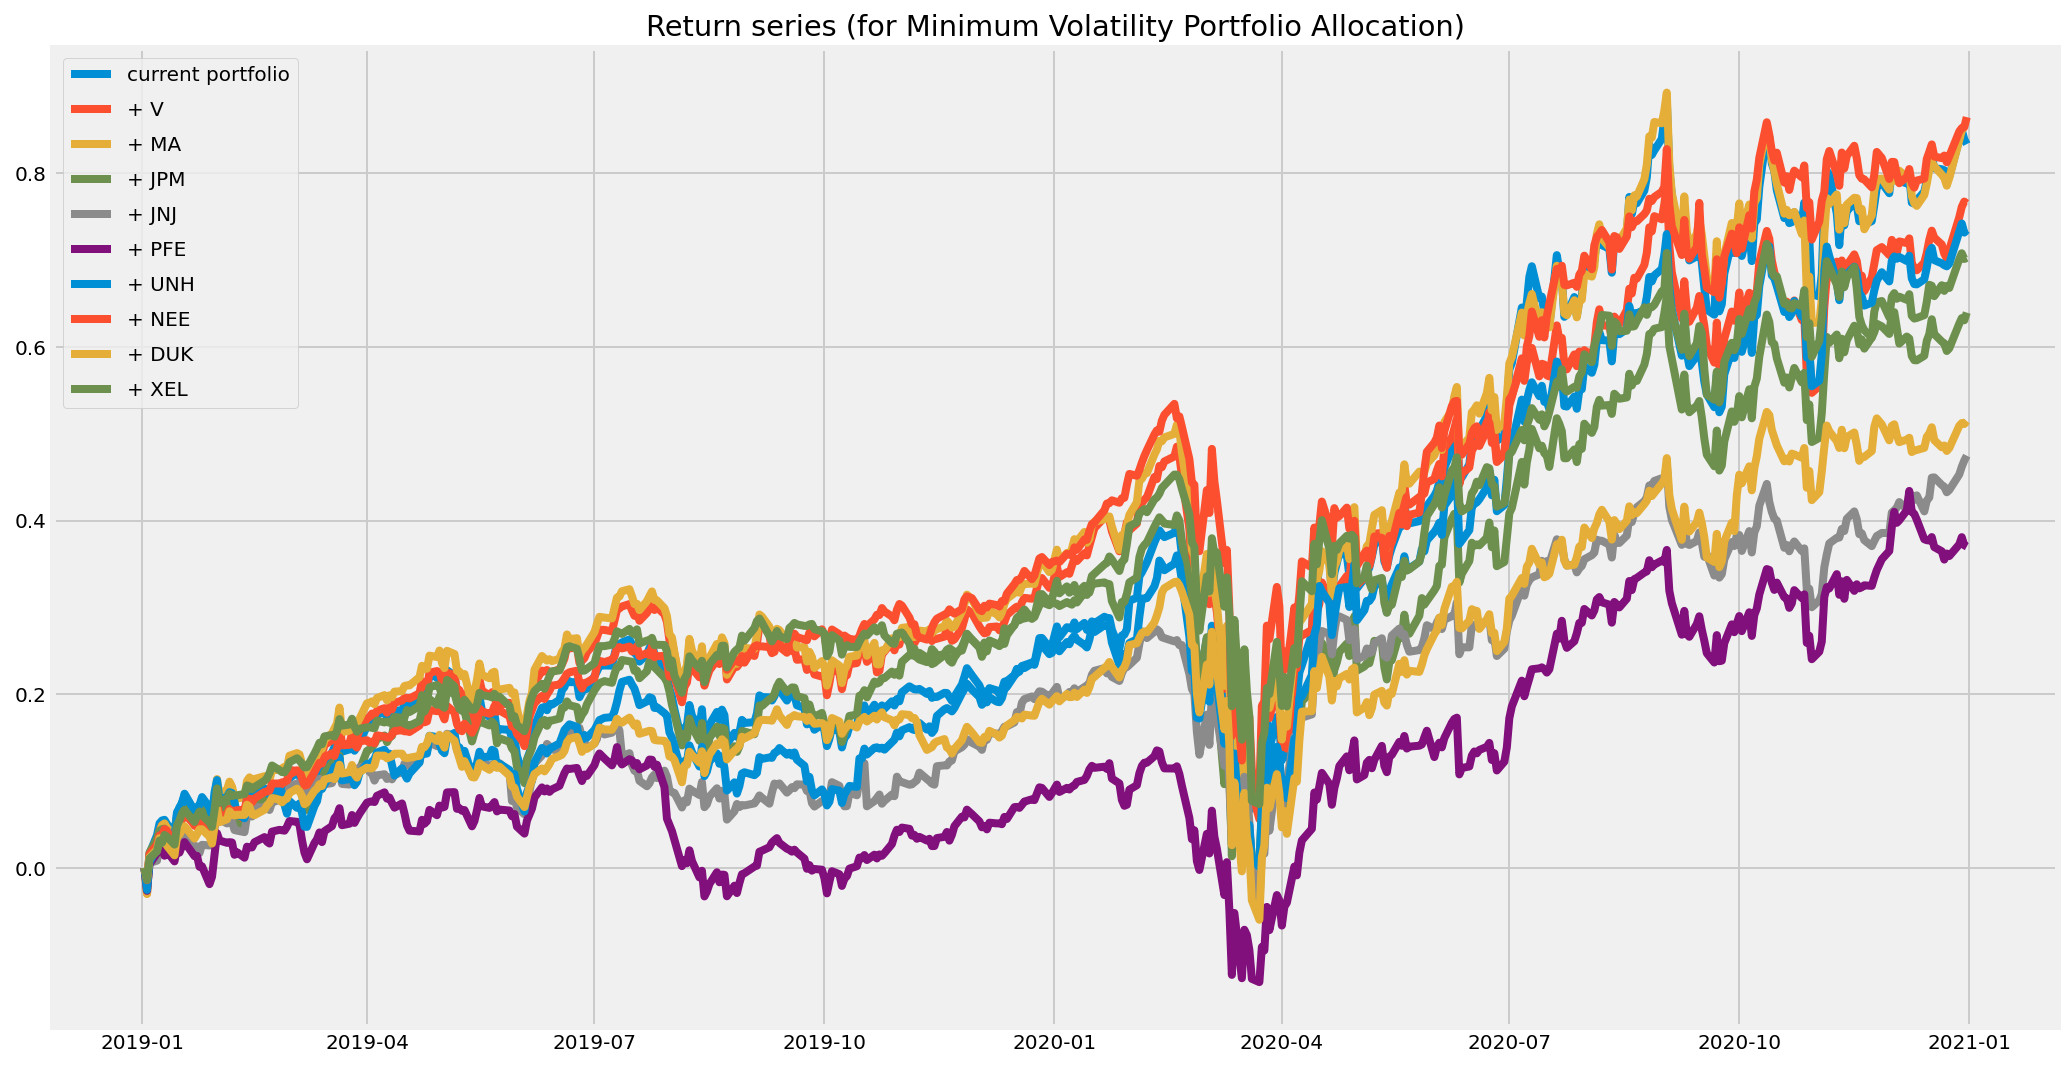

In [ ]:
############################################################
## Minimum Volatility Portfolio Allocation 
###########################################################
fig, ax = plt.subplots(figsize=(16,9)) 
ax.plot(return_series_adj_2y, label = 'current portfolio') 

for sector in sector_res:
    #portfolio returns
    weights = [sector[6], sector[7]]

    sector_closes_2y_return_series_adj = (sector_closes_2y['Adj Close'].pct_change()+ 1).cumprod() - 1 
    #include ticker;
    return_series_adj_2y_new_sector= pd.DataFrame(sector_closes_2y_return_series_adj[sector[12]]).join(pd.DataFrame(return_series_adj_2y)).rename(columns={0: 'portfolio'})

    weighted_return_series_adj = weights* (return_series_adj_2y_new_sector) 

    #Sum the weighted returns for portfolio
    df = weighted_return_series_adj.sum(axis=1)/100

    ax.plot(df, label= "+ "+ sector[12]) 

ax.set_title("Return series (for Minimum Volatility Portfolio Allocation)")
ax.legend()
ax.legend(labelspacing= 0.8)